## Müller-Brown potentialの定義
ポテンシャル関数

Müller-Brownポテンシャルは、以下の形式で記述されます：


$V(x, y) = \sum_{i=1}^4 A_i \exp\left[a_i (x - x_i)^2 + b_i (x - x_i)(y - y_i) + c_i (y - y_i)^2\right]$


ここで、 (x, y)  は座標空間上の点を表し、 $A_i ,  a_i ,  b_i ,  c_i ,  x_i ,  y_i$  は係数です。

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod

In [2]:
class Potential(metaclass=ABCMeta):

    @abstractmethod
    def eval(self):
        pass

    @abstractmethod
    def gradient(self):
        pass

    @abstractmethod
    def gradient_2nd(self):
        pass

class MuellerBrown(Potential):

    def __init__(self,
                 A=None,
                 a=None,
                 b=None,
                 c=None,
                 x0=None,
                 y0=None) -> None:
        self.A = np.array(A if A is not None else [-200, -100, -170, 15])
        self.a = np.array(a if a is not None else [-1, -1, -6.5, 0.7])
        self.b = np.array(b if b is not None else [0, 0, 11, 0.6])
        self.c = np.array(c if c is not None else [-10, -10, -6.5, 0.7])
        self.x0 = np.array(x0 if x0 is not None else [1, 0, -0.5, -1])
        self.y0 = np.array(y0 if y0 is not None else [0, 0.5, 1.5, 1])

    def eval(self, p):
        if isinstance(p, np.ndarray) and p.ndim == 1:
            x_shifted = p[0]-self.x0
            y_shifted = p[1]-self.y0
            return np.dot(self.A, np.exp(self.a*(x_shifted)**2 + self.b*x_shifted*y_shifted + self.c*(y_shifted)**2).T)
        elif isinstance(p, np.ndarray) and p.ndim == 2:
            x_shifted = p[:,0,np.newaxis]-self.x0
            y_shifted = p[:,1,np.newaxis]-self.y0
            return np.dot(self.A, np.exp(self.a*(x_shifted)**2 + self.b*x_shifted*y_shifted + self.c*(y_shifted)**2).T)
        else:
            raise NotImplementedError

    def gradient(self, p):
        if isinstance(p, np.ndarray) and p.ndim == 1:
            x_shifted = p[0]-self.x0
            y_shifted = p[1]-self.y0
            phi = np.exp(self.a*(x_shifted)**2 + self.b*x_shifted*y_shifted + self.c*(y_shifted)**2)
            part_x = np.dot(self.A, (phi*(2*self.a*x_shifted + self.b*y_shifted)).T)
            part_y = np.dot(self.A, (phi*(self.b*x_shifted + 2*self.c*y_shifted)).T)
            return np.array((part_x, part_y))
        elif isinstance(p, np.ndarray) and p.ndim == 2:
            x_shifted = p[:,0,np.newaxis]-self.x0
            y_shifted = p[:,1,np.newaxis]-self.y0
            phi = np.exp(self.a*(x_shifted)**2 + self.b*x_shifted*y_shifted + self.c*(y_shifted)**2)
            part_x = np.dot(self.A, (phi*(2*self.a*x_shifted + self.b*y_shifted)).T)
            part_y = np.dot(self.A, (phi*(self.b*x_shifted + 2*self.c*y_shifted)).T)
            return np.array((part_x, part_y))
        else:
            raise NotImplementedError

    def gradient_2nd(self, p):
        if isinstance(p, np.ndarray) and p.ndim == 1:
            x_shifted = p[0]-self.x0
            y_shifted = p[1]-self.y0
            phi = np.exp(self.a*(x_shifted)**2 + self.b*x_shifted*y_shifted + self.c*(y_shifted)**2)
            part_xx = np.dot(self.A, (phi*(2*self.a+(2*self.a*x_shifted + self.b*y_shifted)**2)).T)
            part_yy = np.dot(self.A, (phi*(2*self.c+(self.b*x_shifted + 2*self.c*y_shifted)**2)).T)
            part_xy = np.dot(self.A, (phi*(self.b+(2*self.a*x_shifted + self.b*y_shifted)*(self.b*x_shifted + 2*self.c*y_shifted))).T)
            return np.array((part_xx, part_yy, part_xy))
        elif isinstance(p, np.ndarray) and p.ndim == 2:
            x_shifted = p[:,0,np.newaxis]-self.x0
            y_shifted = p[:,1,np.newaxis]-self.y0
            phi = np.exp(self.a*(x_shifted)**2 + self.b*x_shifted*y_shifted + self.c*(y_shifted)**2)
            part_xx = np.dot(self.A, (phi*(2*self.a+(2*self.a*x_shifted + self.b*y_shifted)**2)).T)
            part_yy = np.dot(self.A, (phi*(2*self.c+(self.b*x_shifted + 2*self.c*y_shifted)**2)).T)
            part_xy = np.dot(self.A, (phi*(self.b+(2*self.a*x_shifted + self.b*y_shifted)*(self.b*x_shifted + 2*self.c*y_shifted))).T)
            return np.array((part_xx, part_yy, part_xy))
        else:
            raise NotImplementedError

    def plot_surface(self, *, p_list=None):
        x = np.linspace(-1.5, 0.8, 100)
        y = np.linspace(-0.3, 1.6, 100)
        X, Y = np.meshgrid(x, y)
        grids = np.array(list(zip(X.flatten(), Y.flatten())))
        energies = self.eval(grids).reshape(100, 100)
        plt.contourf(X, Y, energies, levels=40, cmap='jet')
        if p_list is not None:
            plt.scatter(p_list[:,0], p_list[:,1], c='red')
        plt.show()

### 構造最適化
#### 停留点の座標
MINIMUM: (-0.558, 1.442), (-0.05, 0.467), (0.623, 0.028)

SADDLE: (-0.822, 0.624)

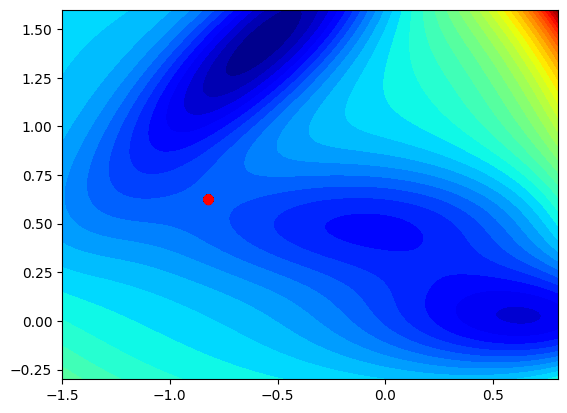

[-0.82200156  0.6243128 ]


In [3]:
p_list = np.zeros((300, 2))
p_list[0] = (-0.822, 0.624)
MB = MuellerBrown()
for i in  range(p_list.shape[0]-1):
    grad = MB.gradient(p_list[i])
    #p_list[i+1] = p_list[i] - 1e-4*grad
    hxx, hyy, hxy = MB.gradient_2nd(p_list[i])
    hessian = np.array([[hxx, hxy], [hxy, hyy]])
    p_list[i+1] = p_list[i] - np.linalg.inv(hessian) @ grad

MB.plot_surface(p_list=p_list)
print(p_list[-1])

## Euclidean Actionの定義
$S_{\beta \hbar}(\boldsymbol{x})=\sum_{i=1}^N \frac{1}{2} \frac{m N}{\beta \hbar}\left(x_i-x_{i-1}\right)^2+\frac{\beta \hbar}{N} \sum_{i=1}^N V\left(x_i\right)$

各ビーズ$x_i$はQ=3N-6次元になることに注意。ただしMBポテンシャルならQ=2

In [4]:
class EuclideanAction():

    def __init__(self,
                 m_au=None,
                 beta_hbar_au=None,
                 *,
                 potential=None):
        self.m_au = m_au if m_au is not None else 1
        self.beta_hbar_au = beta_hbar_au if beta_hbar_au is not None else 1
        if potential is None:
            self.potential = MuellerBrown()
        else:
            self.potential = potential

    def eval(self, p_au):
        N = p_au.shape[0]
        fac1 = 0.5*self.m_au*N/self.beta_hbar_au
        fac2 = self.beta_hbar_au/N
        disp=p_au-np.roll(p_au, 1, axis=0)
        return fac1*np.sum(disp * disp) + fac2*np.sum(self.potential.eval(p_au))

    def gradient(self, p_au):
        N = p_au.shape[0]
        S = np.zeros((N, 2))
        fac1 = self.m_au*N/self.beta_hbar_au
        fac2 = self.beta_hbar_au/N
        for i in range(N):
            idx1 = (i+N)%N
            idx2 = (i-1+N)%N
            idx3 = (i+1+N)%N
            S[i] = fac1*(2*p_au[idx1]-p_au[idx2]-p_au[idx3]) + fac2*self.potential.gradient(p_au[idx1])
        return S

    def gradient_2nd(self, p_au):
        '''
        Returns:
            ret1: (N, 3) array, d^2S/dx_i^2 for i=1,2,...,N, each second derivative is Q x Q matrix
            ret2: scalar, d^2S/dx_ix_j for j=i+1 or i-1, each second derivative is identity matrix
        '''
        N = p_au.shape[0]
        ret1 = np.zeros((N, 3))
        fac1 = 2*self.m_au*N/self.beta_hbar_au
        fac2 = self.beta_hbar_au/N
        for i in range(N):
            idx1 = (i+N)%N
            ret1[i] = fac1*np.array([1, 1, 0]) + fac2*self.potential.gradient_2nd(p_au[idx1])
        ret2 = -self.m_au*N/self.beta_hbar_au
        return ret1, ret2

    def hessian(self, p_au):
        N = p_au.shape[0]
        ret = np.zeros((N, 2, N, 2))
        h1, h2 = self.gradient_2nd(p_au)
        for i in range(N):
            idx1 = (i+N)%N
            idx2 = (i-1+N)%N
            idx3 = (i+1+N)%N
            ret[idx1][0][idx1][0] = h1[idx1][0]
            ret[idx1][1][idx1][1] = h1[idx1][1]
            ret[idx1][0][idx1][1] = h1[idx1][2]
            ret[idx1][1][idx1][0] = h1[idx1][2]
            ret[idx1][0][idx2][0] = h2
            ret[idx1][1][idx2][1] = h2
            ret[idx1][0][idx3][0] = h2
            ret[idx1][1][idx3][1] = h2
        return ret

## Initial guess of ring polymer

EighResult(eigenvalues=array([-749.14455783,  491.04901886]), eigenvectors=array([[-0.7620942 , -0.64746616],
       [ 0.64746616, -0.7620942 ]]))


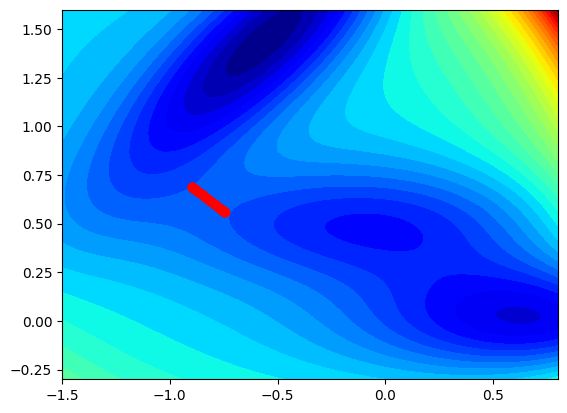

In [5]:
saddle = np.array([-0.822, 0.624])
MB = MuellerBrown()
hxx, hyy, hxy = MB.gradient_2nd(saddle)
hessian = np.array([[hxx, hxy], [hxy, hyy]])
print(np.linalg.eigh(hessian))
z = np.linalg.eigh(hessian)[1][:,0]

N = 50
RP = np.zeros((N, 2))
for i in range(N):
    RP[i] = saddle + 0.1*np.cos(2*np.pi*i/(N-1))*z
MB =MuellerBrown()
MB.plot_surface(p_list=RP)

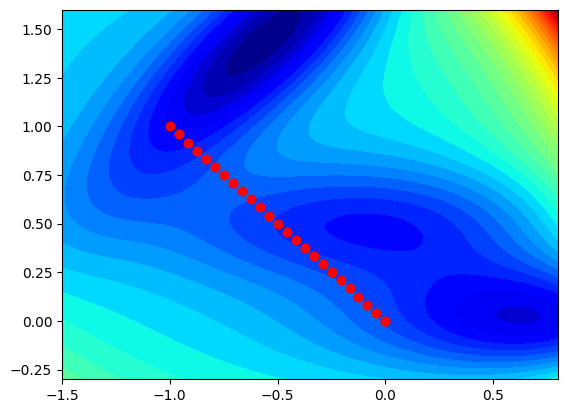

In [170]:
N = 50
RP = np.zeros((N, 2))
for i,j in enumerate(np.linspace(-1,0,25)):
    RP[i] = (j,-j)
    RP[-i] = (j,-j)
MB =MuellerBrown()
MB.plot_surface(p_list=RP)

## 最急降下法

In [ ]:
EA = EuclideanAction()
# print(EA.eval(RP))
# print(EA.gradient(RP))
RP_list = np.zeros((3000, N, 2))
RP_list[0] = RP
for i in range(RP_list.shape[0]-1):
    grad = EA.gradient(RP_list[i])
    RP_list[i+1] = RP_list[i]-1e-3*grad
    print('iter=', i, ', S=', EA.eval(RP_list[i]), ', |g|=', np.linalg.norm(grad))

#MB.plot_surface(p_list=RP_list[-1])
from ipywidgets import interact
import ipywidgets as widgets

def draw_graph(a):
    MB.plot_surface(p_list=RP_list[int(a)])

interact(draw_graph, a=widgets.IntSlider(min=0, max=len(RP_list)-1, step=1, value=0))

iter= 0 , S= -42.41129746264938 , |g|= 7.015942636526467
iter= 1 , S= -42.460884583789934 , |g|= 7.119671650437042
iter= 2 , S= -42.51194944427823 , |g|= 7.225108454454892
iter= 3 , S= -42.56453853647135 , |g|= 7.332260823865263
iter= 4 , S= -42.61869954607791 , |g|= 7.441134546521304
iter= 5 , S= -42.67448134542286 , |g|= 7.551733166974067
iter= 6 , S= -42.731933980808336 , |g|= 7.664057730205104
iter= 7 , S= -42.79110865349969 , |g|= 7.778106521979416
iter= 8 , S= -42.852057693803275 , |g|= 7.893874803855433
iter= 9 , S= -42.91483452764979 , |g|= 8.011354541658188
iter= 10 , S= -42.97949363505192 , |g|= 8.130534126823887
iter= 11 , S= -43.04609049976905 , |g|= 8.251398090514911
iter= 12 , S= -43.11468154948195 , |g|= 8.373926810823498
iter= 13 , S= -43.18532408575823 , |g|= 8.49809621375809
iter= 14 , S= -43.25807620307575 , |g|= 8.6238774690574
iter= 15 , S= -43.33299669616513 , |g|= 8.751236682217105
iter= 16 , S= -43.410144954938694 , |g|= 8.880134584451875
iter= 17 , S= -43.48958

interactive(children=(IntSlider(value=0, description='a', max=2999), Output()), _dom_classes=('widget-interact…

<function __main__.draw_graph(a)>

## Newton-Raphson法（ナイーブ）
- 収束半径が狭いので最急降下法である程度optしてから走らせた方がよい

In [12]:
EA = EuclideanAction()
RP_list = np.zeros((300, N, 2))
RP_list[0] = RP
max_step = 0.1
for i in range(RP_list.shape[0]-1):
    print('iter=', i, ', S=', EA.eval(RP_list[i]), ', |g|=', np.linalg.norm(grad))
    grad = EA.gradient(RP_list[i]).reshape(N*2)
    if i < 100:
        RP_list[i+1] = RP_list[i]-1e-3*grad.reshape(N, 2)
    else:
        hessian = EA.hessian(RP_list[i]).reshape(N*2, N*2)
        delta_x = np.linalg.inv(hessian) @ grad
        delta_x = np.clip(delta_x, -max_step, max_step)
        RP_list[i+1] = RP_list[i]-delta_x.reshape(N, 2)

from ipywidgets import interact
import ipywidgets as widgets

def draw_graph(a):
    MB.plot_surface(p_list=RP_list[int(a)])

interact(draw_graph, a=widgets.IntSlider(min=0, max=len(RP_list)-1, step=1, value=0))

iter= 0 , S= -42.41129746264938 , |g|= 4.182116889609777e-14
iter= 1 , S= -42.460884583789934 , |g|= 7.015942636526467
iter= 2 , S= -42.51194944427823 , |g|= 7.119671650437042
iter= 3 , S= -42.56453853647135 , |g|= 7.225108454454892
iter= 4 , S= -42.61869954607791 , |g|= 7.332260823865263
iter= 5 , S= -42.67448134542286 , |g|= 7.441134546521304
iter= 6 , S= -42.731933980808336 , |g|= 7.551733166974067
iter= 7 , S= -42.79110865349969 , |g|= 7.664057730205104
iter= 8 , S= -42.852057693803275 , |g|= 7.778106521979416
iter= 9 , S= -42.91483452764979 , |g|= 7.893874803855433
iter= 10 , S= -42.97949363505192 , |g|= 8.011354541658188
iter= 11 , S= -43.04609049976905 , |g|= 8.130534126823887
iter= 12 , S= -43.11468154948195 , |g|= 8.251398090514911
iter= 13 , S= -43.18532408575823 , |g|= 8.373926810823498
iter= 14 , S= -43.25807620307575 , |g|= 8.49809621375809
iter= 15 , S= -43.33299669616513 , |g|= 8.6238774690574
iter= 16 , S= -43.410144954938694 , |g|= 8.751236682217105
iter= 17 , S= -43.4

interactive(children=(IntSlider(value=0, description='a', max=299), Output()), _dom_classes=('widget-interact'…

<function __main__.draw_graph(a)>

## PRFO法（Eigenvector-following algorithm）
- 収束半径が狭いので最急降下法である程度optしてから走らせた方がよい
- mode followingだとほぼminに落ちる

In [ ]:
EA = EuclideanAction()
RP_list = np.zeros((300, N, 2))
RP_list[0] = RP
max_step = 0.1
k = None
prev_k = None
for i in range(RP_list.shape[0]-1):
    grad = EA.gradient(RP_list[i]).reshape(N*2)
    print('iter=', i, ', S=', EA.eval(RP_list[i]), ', |g|=', np.linalg.norm(grad))
    if i < 50:
        RP_list[i+1] = RP_list[i]-1e-3*grad.reshape(N, 2)
    else:
        hess = EA.hessian(RP_list[i]).reshape(N*2, N*2)
        hess_eigvals, hess_eigvecs = np.linalg.eigh(hess)
        if k == None:
            k = 0
        else:
            k=0
            #k = np.argmax(np.einsum('ij,i->j',hess_eigvecs, prev_k))
        lambda_k = hess_eigvals[k]
        u_k = hess_eigvecs[:,k]
        ah_k = np.array([[lambda_k, -np.dot(u_k, grad)],[-np.dot(u_k, grad), 0]])
        ah_k_eigvals, ah_k_eigvecs = np.linalg.eigh(ah_k)
        gamma_k = ah_k_eigvals[1]*ah_k_eigvecs[1,1] # the largest eigenvalue

        lambda_n = np.delete(hess_eigvals, k)
        u_n = np.delete(hess_eigvecs, k, axis=1)
        ah_n = np.zeros((N*2, N*2))
        for j in range(N*2-1):
            ah_n[j,j] = lambda_n[j]
        for j in range(N*2-1):
            ah_n[N*2-1, j] = -np.dot(u_n[:,j], grad)
            ah_n[j, N*2-1] = -np.dot(u_n[:,j], grad)
        ah_n_eigvals, ah_n_eigvecs = np.linalg.eigh(ah_n)
        gamma_n = ah_n_eigvals[0]*ah_n_eigvecs[N*2-1,0] # the smallest eigenvalue

        uf = np.einsum('ij,i->j', hess_eigvecs, grad)
        gamma = np.insert(gamma_n*np.ones(N*2-1), k, gamma_k)
        delta_x = np.einsum('j,ij->i', uf/(hess_eigvals-gamma), hess_eigvecs)
        delta_x = np.clip(delta_x, -max_step, max_step)
        RP_list[i+1] = RP_list[i]-delta_x.reshape(N, 2)
        prev_k = u_k


#MB.plot_surface(p_list=RP_list[-1])
from ipywidgets import interact
import ipywidgets as widgets

def draw_graph(a):
    MB.plot_surface(p_list=RP_list[int(a)])

interact(draw_graph, a=widgets.IntSlider(min=0, max=len(RP_list)-1, step=1, value=0))

iter= 0 , S= -42.41129746264938 , |g|= 7.015942636526467
iter= 1 , S= -42.460884583789934 , |g|= 7.119671650437042
iter= 2 , S= -42.51194944427823 , |g|= 7.225108454454892
iter= 3 , S= -42.56453853647135 , |g|= 7.332260823865263
iter= 4 , S= -42.61869954607791 , |g|= 7.441134546521304
iter= 5 , S= -42.67448134542286 , |g|= 7.551733166974067
iter= 6 , S= -42.731933980808336 , |g|= 7.664057730205104
iter= 7 , S= -42.79110865349969 , |g|= 7.778106521979416
iter= 8 , S= -42.852057693803275 , |g|= 7.893874803855433
iter= 9 , S= -42.91483452764979 , |g|= 8.011354541658188
iter= 10 , S= -42.97949363505192 , |g|= 8.130534126823887
iter= 11 , S= -43.04609049976905 , |g|= 8.251398090514911
iter= 12 , S= -43.11468154948195 , |g|= 8.373926810823498
iter= 13 , S= -43.18532408575823 , |g|= 8.49809621375809
iter= 14 , S= -43.25807620307575 , |g|= 8.6238774690574
iter= 15 , S= -43.33299669616513 , |g|= 8.751236682217105
iter= 16 , S= -43.410144954938694 , |g|= 8.880134584451875
iter= 17 , S= -43.48958

interactive(children=(IntSlider(value=0, description='a', max=299), Output()), _dom_classes=('widget-interact'…

<function __main__.draw_graph(a)>

In [9]:
np.set_printoptions(suppress=True)
np.linalg.eigh(EA.hessian(RP_list[-1]).reshape(N*2, N*2))

EighResult(eigenvalues=array([-11.11478302,   0.15165736,   3.89220871,   4.91460078,
         5.41903495,   7.39754307,   8.21021697,  11.41253312,
        12.28287669,  16.87757173,  17.2969338 ,  23.44274317,
        23.67615891,  30.09266988,  30.90959867,  31.32651329,
        31.60156739,  32.42163927,  34.65203187,  34.92408531,
        38.91617363,  39.17925266,  40.33151451,  40.85046079,
        45.40833323,  45.4514805 ,  50.02989757,  50.77403504,
        53.17242009,  53.17346623,  60.55419364,  61.35241138,
        62.37151748,  62.45612135,  71.17138972,  71.80331793,
        73.41370995,  73.46142573,  82.19509974,  82.71034154,
        85.35339216,  85.48113975,  93.84028178,  94.19182799,
        97.70346429,  97.8837968 , 106.01914466, 106.02781868,
       110.1981115 , 110.41785406, 117.96566006, 118.56978654,
       122.63448731, 122.85670261, 129.81946778, 131.29832827,
       134.81824019, 135.00067711, 141.56819129, 143.97617342,
       146.55147424, 146.6919812